Investigate the glacier-scale and regional-scale trend in water area over time

In [1]:
import os
import rasterio as rio
import numpy as np
import shapely 
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
import matplotlib as mpl

In [2]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_datasets = os.path.join(folder_HMA, 'Datasets')
fp_rgi = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_full_rgi.shp')
fp_dc = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_dc_rgi.shp')
fp_regions = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'subregion_boundaries.shp')

In [3]:
# open the rgi gdf, regions gdf
rgi_gdf = gpd.read_file(fp_rgi).to_crs("ESRI:102025")
dc_gdf = gpd.read_file(fp_dc).to_crs("ESRI:102025")
regions_gdf = gpd.read_file(fp_regions).to_crs("ESRI:102025")

# add the o3region as a column to each rgi
regions_gdf = regions_gdf.rename({"id":"o3region"}, axis=1)
rgi_gdf = rgi_gdf.sjoin(regions_gdf[["o3region","geometry"]])
dc_gdf = dc_gdf.sjoin(regions_gdf[["o3region","geometry"]])

In [4]:
# matplotlib stuff
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

In [5]:
# open the water by distance data for each glacier, format into a single df
c=0

# list to hold all the info
df_all = []

for idx, row in rgi_gdf.iterrows():
    c+=1
    # if c>2: continue
    
    rgi_id = row['rgi_id']
    o1region = row['o1region']
    o2region = row['o2region']
    o3region = row['o3region']
    
    # if o1region!='15':continue
    # print progress
    # print(c, "of", len(rgi_gdf), rgi_id)
    if c%100==0: print(c, "of", len(rgi_gdf), rgi_id)

    # open glacier-specific info    
    path_open = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'glacier_slopes.csv')
    df_g = pd.read_csv(path_open, index_col=None, header=0).squeeze()
    
    # we are only going to keep the main branch
    df_g = df_g[['distance','1_z_smooth','1_slope']].rename({'1_z_smooth':'z','1_slope':'slope'}, axis=1)
    
    # normalize to n bands along glacier
    n_bands = 50
    mind = np.nanmin(df_g['distance'])
    maxd = np.nanmax(df_g['distance'])
    norm_bands = np.linspace(0, maxd+1, n_bands+1)    
    
    # for each band
    for i in range(n_bands):
        
        # get rows that correspond to these bands only
        bmin = norm_bands[i]
        bmax = norm_bands[i+1]
        df_g_b = df_g[ (df_g['distance']>=bmin) & (df_g['distance']<bmax) ]
        
        # mean of each column
        df_g_b = df_g_b.mean(axis=0)
        
        # initialize dic to store info
        out_dic = {'rgi_id':rgi_id, 'o1region':row['o1region'], 'o2region':row['o2region'], 'o3region':row['o3region'],
               'length':maxd, 'band':i, 'z':df_g_b['z'], 'slope':df_g_b['slope'] }
        
        # add dictionary to list, and we'll concat to df all at once
        df_all.append(out_dic)

# combine into df holding water within distance bands in each year
df_all = pd.DataFrame(df_all)

print("All done!")

100 of 769 RGI2000-v7.0-G-14-06944
200 of 769 RGI2000-v7.0-G-13-71307
300 of 769 RGI2000-v7.0-G-14-15108
400 of 769 RGI2000-v7.0-G-14-32564
500 of 769 RGI2000-v7.0-G-15-01330
600 of 769 RGI2000-v7.0-G-15-05352
700 of 769 RGI2000-v7.0-G-15-08609
All done!


In [6]:
# create another df where glacier elevations are normalized from 0-1
df_all_norm = []

for rgi_i in df_all['rgi_id'].unique():
    
    # subset to this rgi's data
    g_df = df_all[df_all['rgi_id']==rgi_i]

    # get min, max elevation so we can normalize
    norm_max = np.nanmax(g_df['z'].values)
    norm_min = np.nanmin(g_df['z'].values)

    # add region info and such
    g_df_norm = pd.DataFrame((g_df['z']-norm_min) / (norm_max-norm_min))
    g_df_norm['slope'] = g_df['slope']
    g_df_norm['rgi_id'] = g_df['rgi_id']
    g_df_norm['o1region'] = g_df['o1region']
    g_df_norm['o2region'] = g_df['o2region']
    g_df_norm['o3region'] = g_df['o3region']
    g_df_norm['length'] = g_df['length']
    g_df_norm['band'] = g_df['band']
    # break
    # add to list
    df_all_norm.append(g_df_norm)
    
df_all_norm = pd.concat(df_all_norm)

In [7]:
# load in the list of lake-terminating glaciers, so we can remove those if we want
path_open = os.path.join(folder_datasets, 'lake-terminating glaciers', 'rgi_lake_terminating.csv')
df_lake_term = pd.read_csv(path_open)
rgi_lake_term = df_lake_term['rgi_id'].values

In [8]:
# lets load list of glacier with substanial sgls so we can compare
path_open = os.path.join(folder_datasets, 'substantial_glaciers.csv')
df_substantial = pd.read_csv(path_open)
rgi_substantial = df_substantial['rgi_id']

In [9]:
# create subsets of lake terminating vs non-lake terminating so we can compare
df_all_norm_lt = df_all_norm[df_all_norm['rgi_id'].isin(rgi_lake_term)]
df_all_norm_nlt = df_all_norm[~df_all_norm['rgi_id'].isin(rgi_lake_term)]

# choose which to use for all of the following regional plots
df_to_use_from_here = df_all_norm_nlt  #df_all_norm_percent, df_all_norm_percent_nlt

# lets make a separate df that includes only longer glaciers
df_long = df_to_use_from_here[df_to_use_from_here['length']>=2000]

In [10]:
print(len(df_to_use_from_here['rgi_id'].unique()))
print(len(df_long['rgi_id'].unique()))

747
648


In [11]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

In [12]:
# plot a single glacier's data over time
def plot_single_glacier(rgi_id, glacier_name):
    # plot annual timeseries of a single glacier ( provide either glacier name or rgi_id)
    rgi_id = rgi_id # choose which you want to provide
    glacier_name = glacier_name


    # get the rgi_id if glacier name was provided
    if glacier_name: rgi_id = rgi_gdf[rgi_gdf['glac_name'].str.contains(glacier_name)==True]['rgi_id'].values[0]

    # subset to this glacier's data
    g_df = df_all_norm[df_all_norm['rgi_id']==rgi_id]
    
    # initiate figure
    fig,axs = plt.subplots(figsize=(6,3))

    # define xs of the plot
    xs = np.linspace(0, 1, len(g_df))

    # plot
    axs.scatter(xs, g_df['z'], c=g_df['slope'].values)

    # formatting
    axs.grid(zorder=1, linestyle='dashed', linewidth=0.5)
    axs.set_xlabel("Distance from terminus")
    axs.set_ylabel("Elevation")
    axs.set_ylim(0,)

    # title
    glacier_name = rgi_gdf[rgi_gdf['rgi_id']==rgi_id]['glac_name'].values[0]
    axs.set_title(f"Name: {glacier_name}\nRGI_ID: {rgi_id}")

    plt.tight_layout()
    

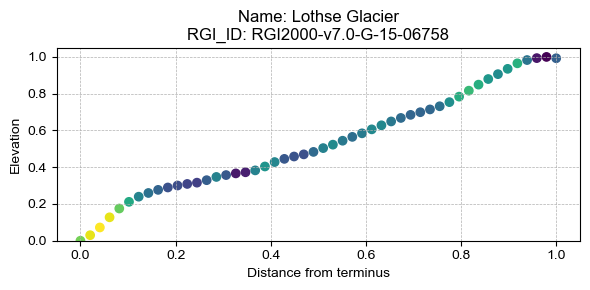

In [13]:
rgi_id = 'RGI2000-v7.0-G-15-08331' # choose which you want to provide
glacier_name = 'Loth'
plot_single_glacier(rgi_id, glacier_name)

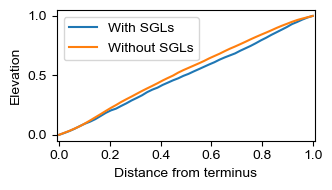

In [14]:
### start figure here
df_to_use = df_all_norm_nlt


# define xs of the plot
xs = np.linspace(0, 1, len(df_to_use['band'].unique()))

# initiate figure
fig,axs = plt.subplots(figsize=(3.5,2))

# with sgls
plotting = df_to_use[df_to_use['rgi_id'].isin(rgi_substantial)]
zs = plotting[['band','z']].groupby('band').median()['z']
slopes = plotting[['band','slope']].groupby('band').median()['slope']
axs.plot(xs, zs, label='With SGLs')

# without sgls
plotting = df_to_use[~df_to_use['rgi_id'].isin(rgi_substantial)]
zs = plotting[['band','z']].groupby('band').median()['z']
slopes = plotting[['band','slope']].groupby('band').median()['slope']
axs.plot(xs, zs, label='Without SGLs')

# formatting
axs.legend()
# axs.grid(zorder=1, linestyle='dashed', linewidth=0.5)
axs.set_xlabel("Distance from terminus")
axs.set_ylabel("Elevation")
axs.set_xlim(-0.01,1.01)
# axs.set_ylim(-1,0)

plt.tight_layout()

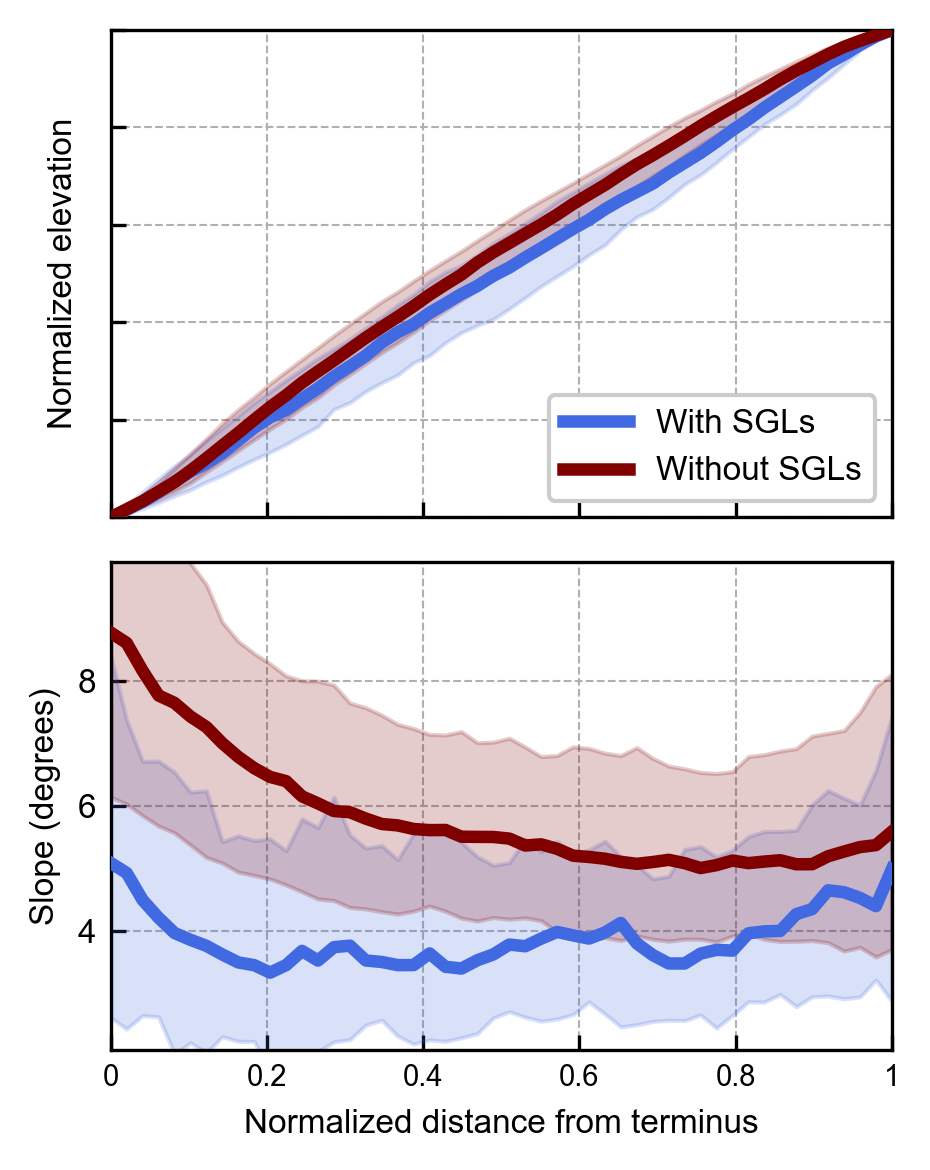

In [32]:
### start figure here
df_to_use = df_all_norm_nlt

# define xs of the plot
xs = np.linspace(0, 1, len(df_to_use['band'].unique()))

# colors
c1 = 'royalblue'
c2 = 'maroon'
lw=3

# initiate figure
fig,axs = plt.subplots(2,1, figsize=(3.2,4), sharex=True, dpi=300)

# with sgls
plotting = df_to_use[df_to_use['rgi_id'].isin(rgi_substantial)]
avgs = plotting[['band','z','slope']].groupby('band').median()
mins = plotting[['band','z','slope']].groupby('band').quantile(.25)
maxs = plotting[['band','z','slope']].groupby('band').quantile(.75)
axs[0].plot(xs, avgs['z'], c=c1, label='With SGLs', linewidth=lw, zorder=3)
axs[1].plot(xs, avgs['slope'], c=c1, label='With SGLs', linewidth=lw, zorder=3)
axs[0].fill_between(xs, mins['z'], maxs['z'], color=c1, alpha=0.2, zorder=2)
axs[1].fill_between(xs, mins['slope'], maxs['slope'], color=c1, alpha=0.2, zorder=2)

# without sgls
plotting = df_to_use[~df_to_use['rgi_id'].isin(rgi_substantial)]
avgs = plotting[['band','z','slope']].groupby('band').median()
mins = plotting[['band','z','slope']].groupby('band').quantile(.25)
maxs = plotting[['band','z','slope']].groupby('band').quantile(.75)
axs[0].plot(xs, avgs['z'], c=c2, label='Without SGLs', linewidth=lw, zorder=3)
axs[1].plot(xs, avgs['slope'], c=c2, label='Without SGLs', linewidth=lw, zorder=3)
axs[0].fill_between(xs, mins['z'], maxs['z'], color=c2, alpha=0.2, zorder=2)
axs[1].fill_between(xs, mins['slope'], maxs['slope'], color=c2, alpha=0.2, zorder=2)

# formatting
for ax in axs:
    ax.set_xlim(0,1)
    ax.set_xticks(np.arange(0,1.1,0.2), ["0","0.2","0.4","0.6","0.8","1"], fontsize=7)
    ax.tick_params(axis="both",direction="in")
    ax.grid(zorder=1, linestyle='dashed', linewidth=0.5)

axs[0].set_yticks(np.arange(0,1.1,0.2), [], fontsize=7)
axs[1].set_yticks([4,6,8],[4,6,8], fontsize=8)

axs[0].legend(framealpha=1, loc='lower right', fontsize=8)
axs[1].set_xlabel("Normalized distance from terminus", fontsize=8)

axs[0].set_ylabel("Normalized elevation", fontsize=8)
axs[1].set_ylabel("Slope (degrees)", fontsize=8)

axs[0].set_ylim(0,1)
axs[1].set_ylim(3.5,10.5)
axs[1].set_ylim(2.1,9.9)

plt.tight_layout()

save=1
if save:
    plt.savefig(os.path.join(folder_HMA,'Figures','slope and dhdt',f'slope.png'),
                transparent=False, bbox_inches='tight', dpi=300)